# Computing an Earth-Moon Trajectory in ThreeBodyProblem.jl
is notebook sets up some parameters for the Earth/Moon Circular Restricted Three-Body Problem (CR3BP), finds the Lagrange points, plots the effective potential contours, and solves the CR3BP ODE's to generate a trajectory.

## First we'll need to import ThreeBodyProblem.jl as well as OrdinaryDiffEq and Plots

In [1]:
@time using ThreeBodyProblem
@time using OrdinaryDiffEq
@time using Plots

 11.773086 seconds (24.30 M allocations: 1.689 GiB, 6.29% gc time, 0.03% compilation time)
  0.000097 seconds (99 allocations: 7.688 KiB)
  0.000090 seconds (99 allocations: 7.688 KiB)


## Declare the Earth-Moon system parameters
When declaring variables, I like to add a comment with the units in curly brackets as well as a description

In [2]:
μ₁ = 398600 # {km³/s²} gravitational parameter of Earth
μ₂ = 4902   # {km³/s²} gravitational parameter of the Moon
d = 384400  # {km} average distance between Earth and the Moon

p = [μ₁, μ₂, d] # concatenate the parameters into one array

3-element Vector{Int64}:
 398600
   4902
 384400

### We can use the parameter vector, p, as a function argument instead of a System() struct or mass parameter μ.

In [3]:
L1 = computeL1(p) # calculate the Lagrange point L1 for the given system parameters p

3-element Vector{Float64}:
 321713.8570517506
      0.0
      0.0

### There is a function to compute each Lagrange point, or you can calculate all of them at once and just select the one you're interested in.
The Lagrange points are the equilibrium points of the CR3BP, where the gravitational forces from the primary and secondary balance out the centrifugal force of the rotating frame.

In [4]:
Lpts = computeLpts(p)
L4 = Lpts[4]

3-element Vector{Float64}:
 187530.06329584488
 332900.16521473817
      0.0

### We can compute the x-coordinates of the primary and secondary as well as the mean motion (i.e. average angular velocity)

In [5]:
d₁,d₂ = computed1d2(p) # {km} directional distances of Primary and Secondary bodies from origin

(-4669.936704155122, 379730.0632958449)

In [6]:
n = sqrt((μ₁ + μ₂)/d^3) # {rad/s} mean motion of the system

2.665310298373478e-6

## Plotting the gravitational potential contours
Here we set up a mesh grid of 100 points centered at the origin and compute the effective potential energy at each point

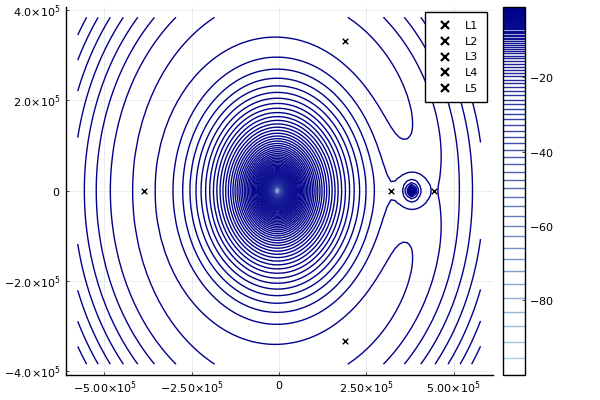

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [7]:
N = 100 # using 100 sample points in each direction
X = range(-1.5*d,1.5*d,length=N)
Y = range(-d,d,length=N)

# f(x,y) = -computeUeff([x,y,0,0,0,0],p) # negative effective potential (also -computeΩ())
f(x,y) = begin
    -(x^2 + y^2)*n^2/2 - μ₁/sqrt((x-d₁)^2 + y^2) - μ₂/sqrt((x-d₂)^2 + y^2) # showing the inner workings of computeUeff()
end

# plot the Lagrange points on top
for i = 1:5
    plot!([Lpts[i][1]],[Lpts[i][2]], label=string("L",i),markershape=:x,seriestype=:scatter,markercolor=:black)
end

levels = -exp10.(range(2,0,length=100));
contour!(X,Y,f,levels=levels,fill=false,c = :blues)

We can see the contours are steep around the primary and secondary bodies.

### Some more parameters describing our system

In [8]:
Rₑ = 6378.0 # {km} radius of the Earth
Rₘ = 1738.0 # {km} radius of the Moon

1738.0

## Define the initial conditions of our injection orbit

In [9]:
h = 200.0           # {km} altitude of parking orbit
vᵢ = 10.92367104    # {km/s} injection velocity in rotating frame
ϕ = 47.70061087     # {°} injection angle, measured from +y

47.70061087

In [10]:
r₀ = [d₁ - (Rₑ + 200)*cosd(ϕ); -(Rₑ + 200)*sind(ϕ); 0]
v₀ = vᵢ*[sind(ϕ); -cosd(ϕ); 0];
rv₀ = [r₀;v₀] # {km; km/s} our initial state 

6-element Vector{Float64}:
 -9096.961145507787
 -4865.340542620438
     0.0
     8.07956515432666
    -7.3516811619605145
     0.0

### Make sure to use float values rather than integers (e.g. 0. instead of 0) when setting up the timespan for the solver.

In [11]:
tspan = (0.,86400*6.) # {sec} 6 day span

(0.0, 518400.0)

### Here we set up our ODE and solve it

In [12]:
prob = ODEProblem(CR3BPdynamics!,rv₀,tspan,p) # CR3BPdynamics! is our in-place dynamics function
sol = solve(prob, TsitPap8(), reltol=1e-6);

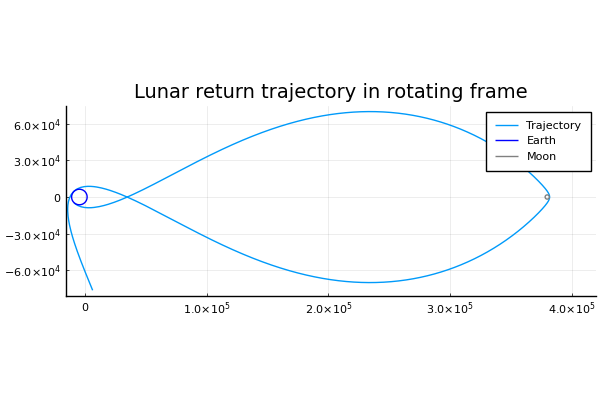

In [13]:
plot(sol,vars=(1,2),title="Lunar return trajectory in rotating frame",label="Trajectory")
plot!(circle(Rₑ,[d₁;0]),color="blue",label="Earth")
plot!(circle(Rₘ,[d₂;0]),color="gray",label="Moon",aspect_ratio=:equal)

### Convert to the inertial frame and plot

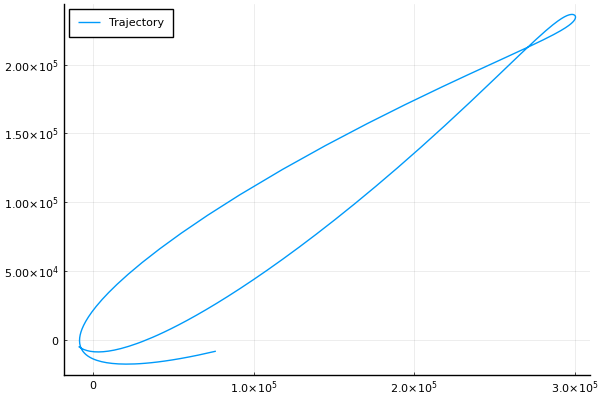

In [14]:
rv_inert = [rot2inert(sol.u[i],sol.t[i],p) for i = 1:length(sol)]
x = [rv_inert[i][1] for i = 1:length(rv_inert)]
y = [rv_inert[i][2] for i = 1:length(rv_inert)]
plot(x,y,legend=:topleft,label="Trajectory")